<a href="https://colab.research.google.com/github/Sanim27/GAN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)

            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )
    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)


def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN,
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128

lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5099572.90it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133505.51it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1268190.90it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4703834.26it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.9046908686161037, discriminator loss: 0.5122164470553404


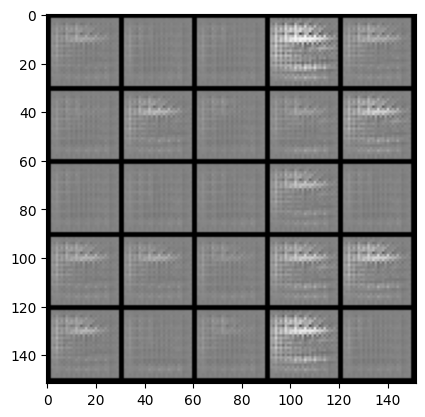

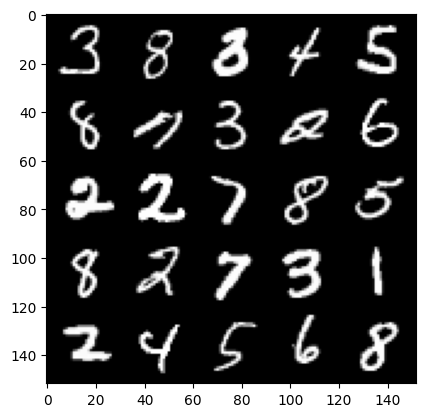

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.9541086973547932, discriminator loss: 0.22362141075730302


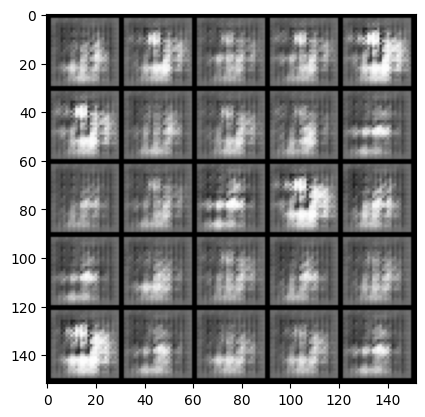

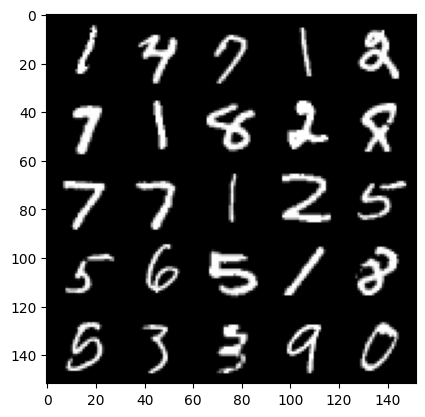

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.4479947760105132, discriminator loss: 0.4475332159250976


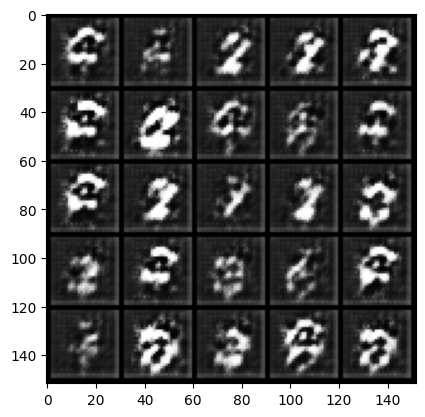

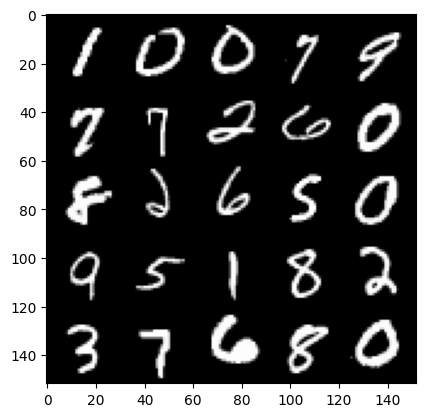

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.0557891910374169, discriminator loss: 0.5465430232882498


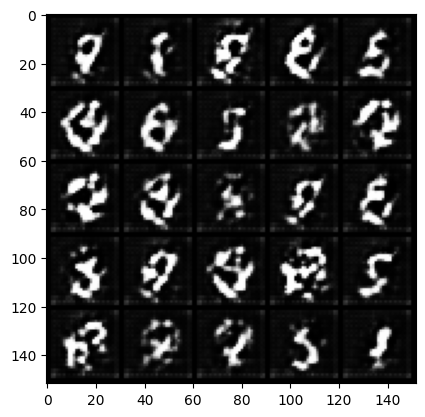

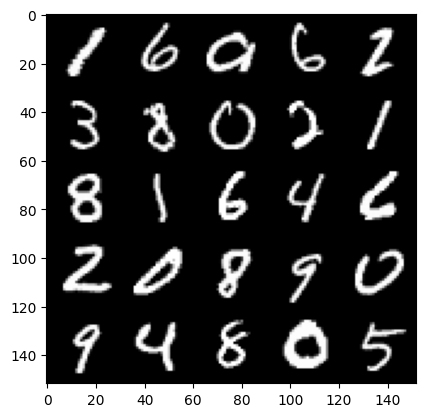

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 0.9197464421391491, discriminator loss: 0.584919562458992


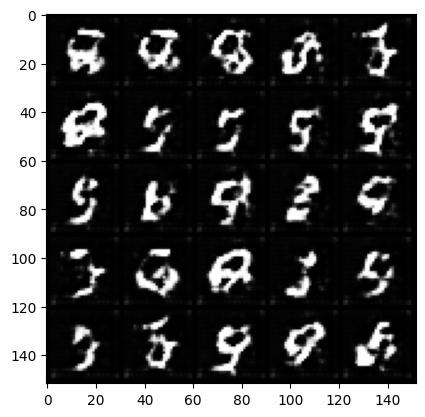

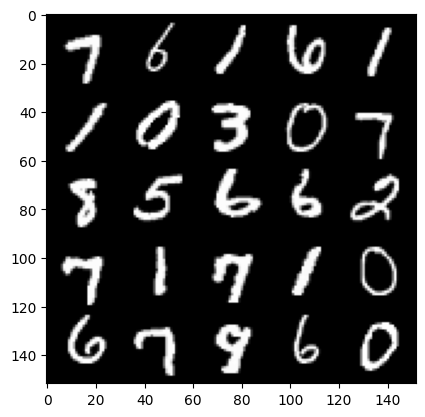

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.8635317754745481, discriminator loss: 0.6137240216732022


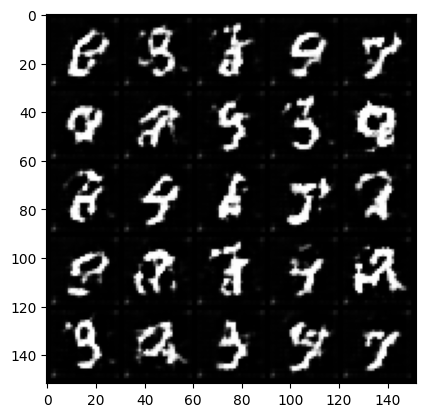

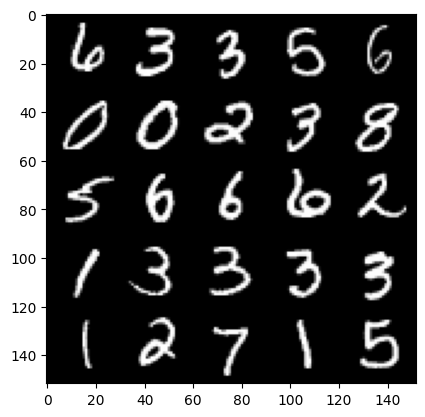

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.8207839513421068, discriminator loss: 0.638026228070259


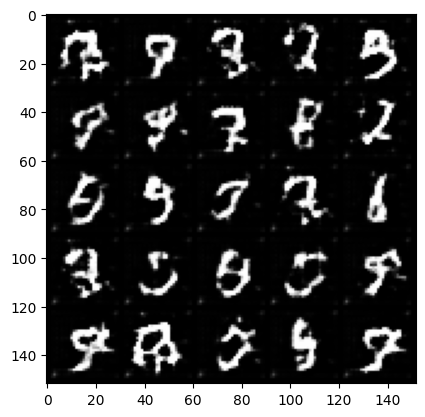

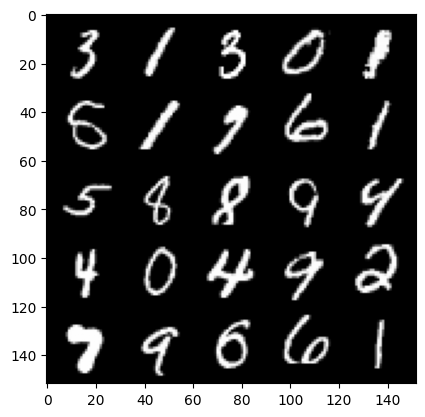

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.7916325851678832, discriminator loss: 0.6537782649993904


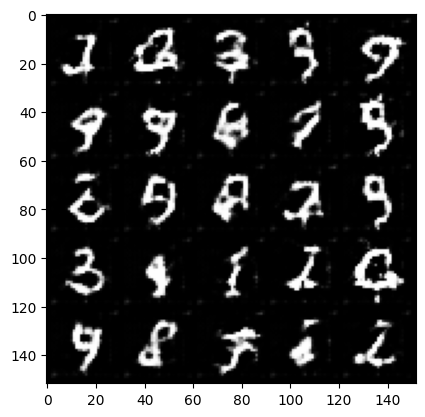

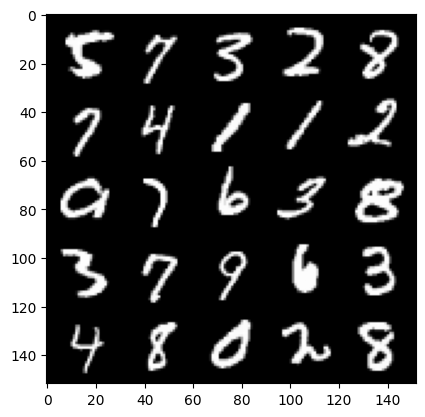

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.7757952948808675, discriminator loss: 0.6681076229810711


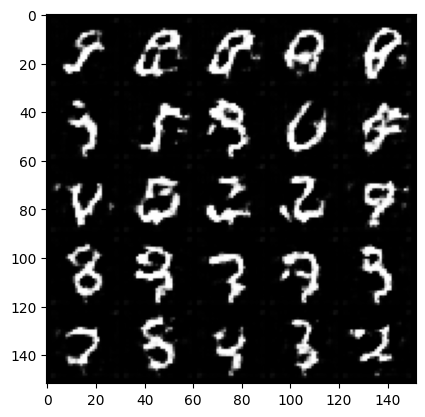

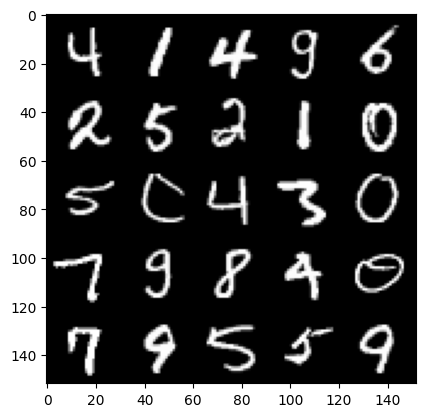

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.7608255672454836, discriminator loss: 0.6719063446521764


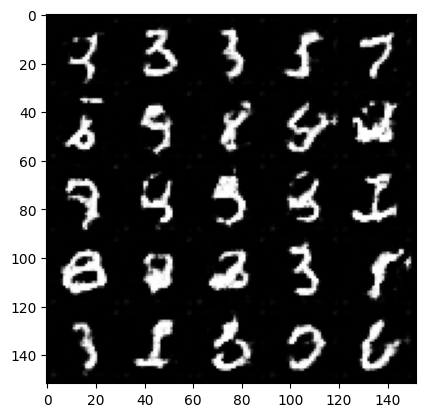

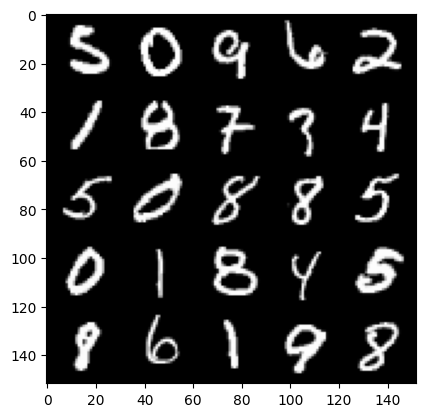

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.7567842090129844, discriminator loss: 0.677354622840881


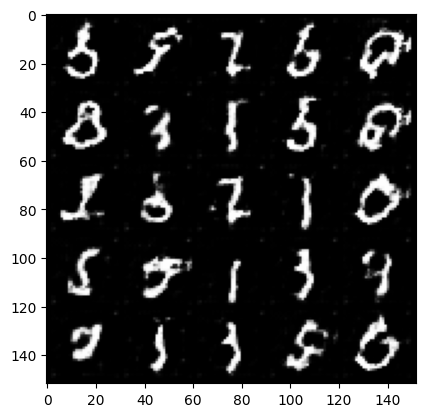

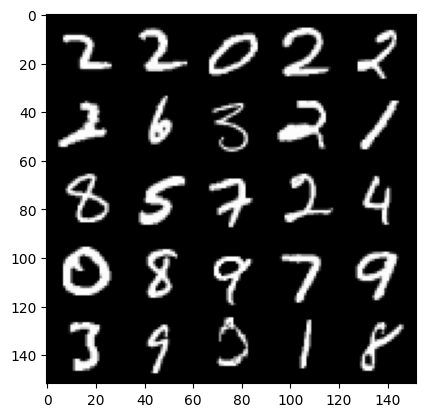

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.7442180964946747, discriminator loss: 0.6845526891946788


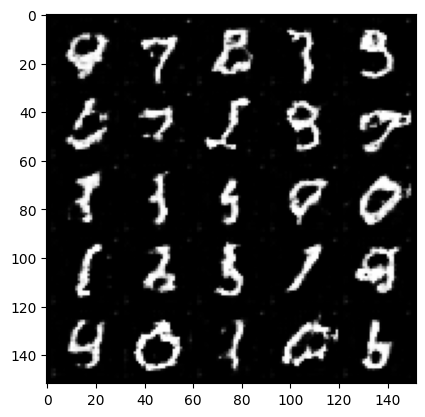

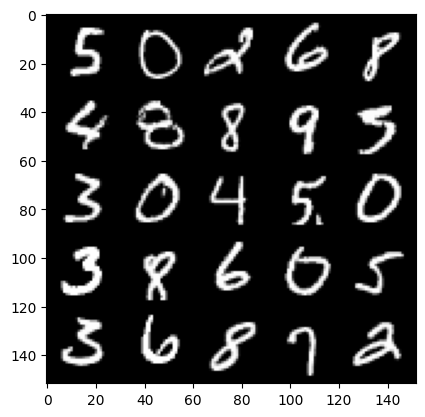

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.736088548660278, discriminator loss: 0.6917563360929488


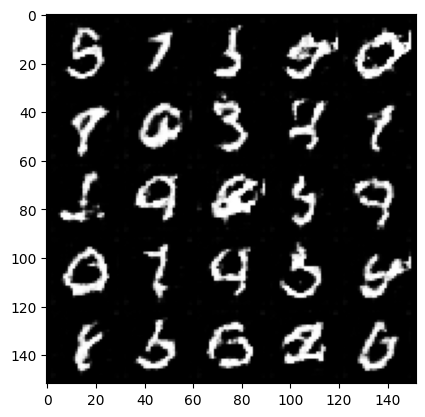

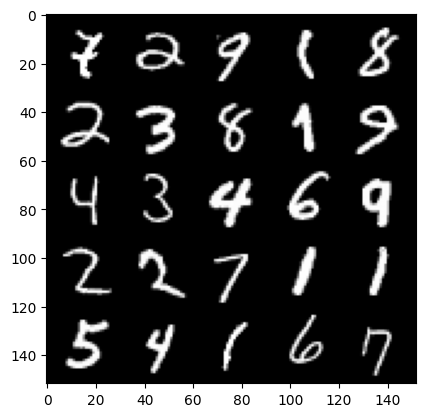

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.7236707655787467, discriminator loss: 0.6955639295577994


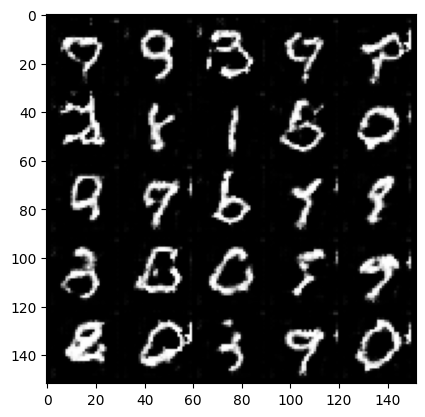

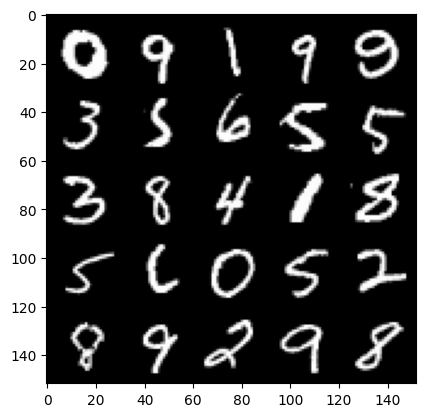

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.7191782392263405, discriminator loss: 0.6967230346202851


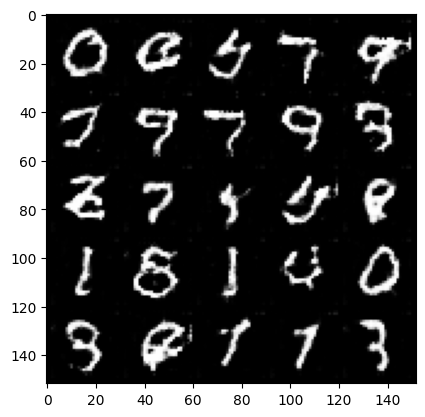

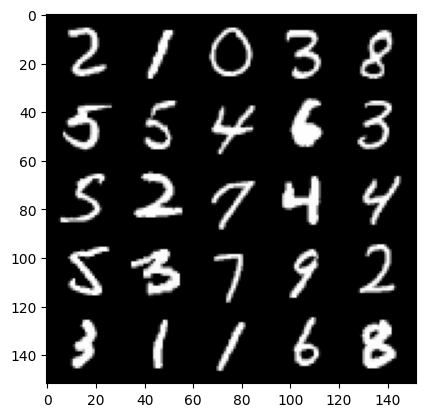

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.7192588628530496, discriminator loss: 0.6975229095220571


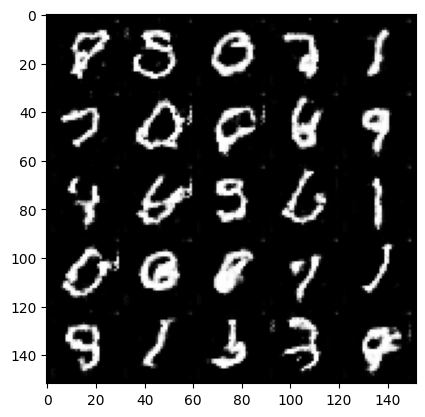

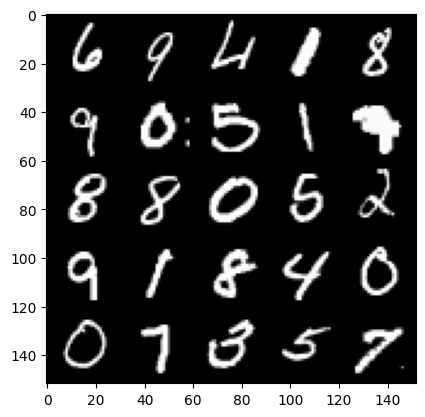

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.7154343852996834, discriminator loss: 0.6990737717151638


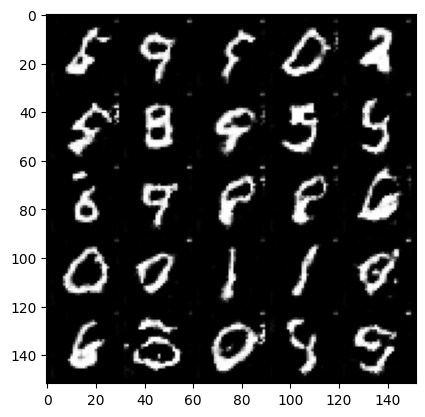

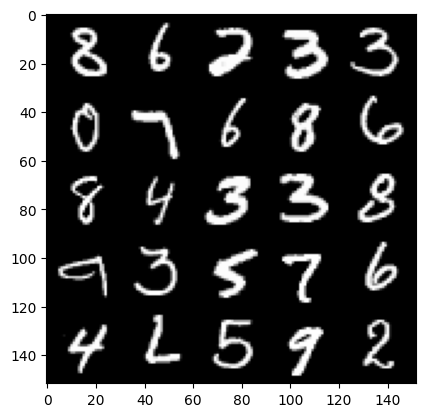

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.7106862819790842, discriminator loss: 0.7004753218889231


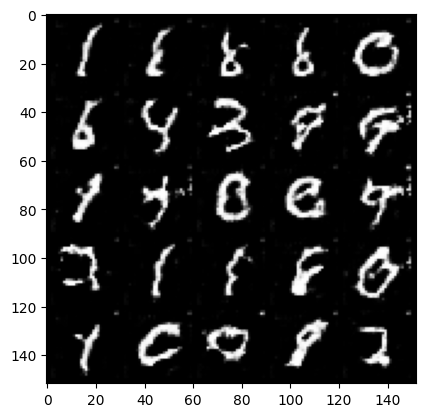

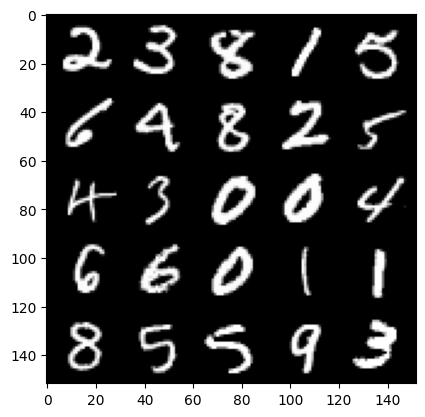

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.7069724142551428, discriminator loss: 0.7012640767097478


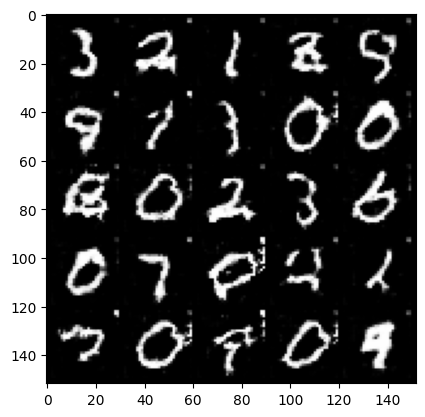

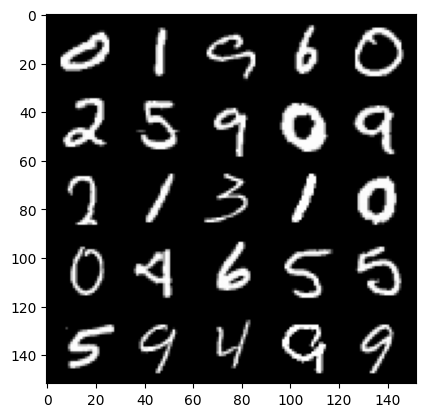

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.7026334199905395, discriminator loss: 0.7012296426296228


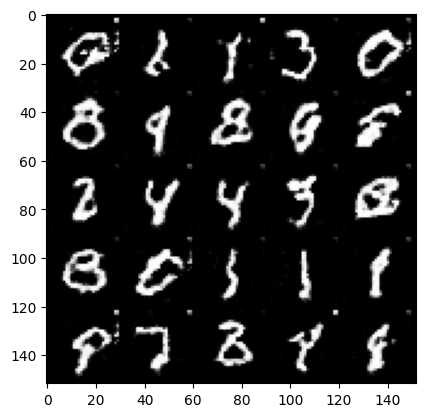

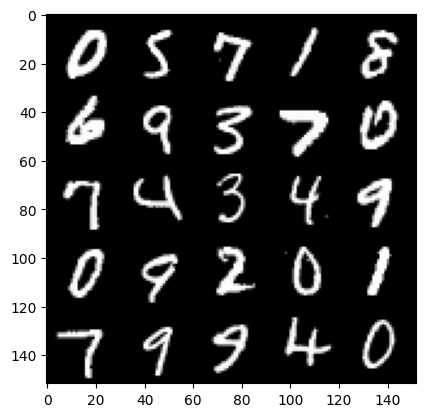

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.7028195209503165, discriminator loss: 0.7004875320196156


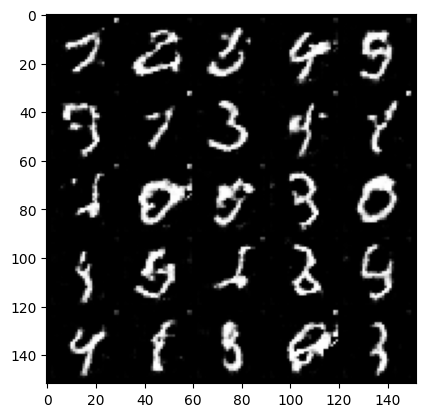

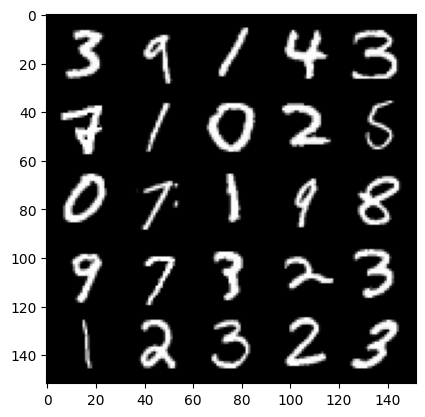

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.7022150875329974, discriminator loss: 0.6999837313890459


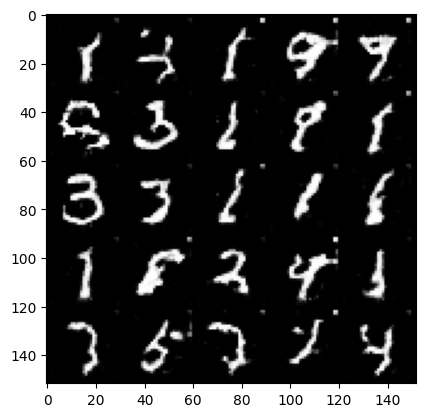

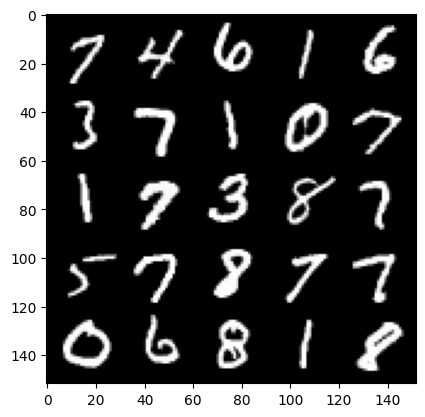

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 0.7024267446994784, discriminator loss: 0.6995697796344765


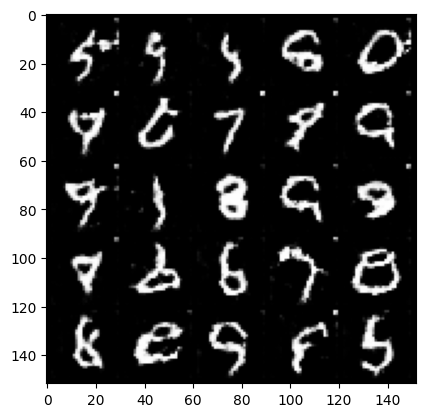

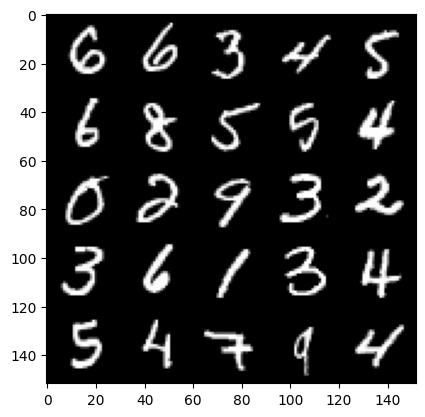

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.7006199975013736, discriminator loss: 0.6992418903112415


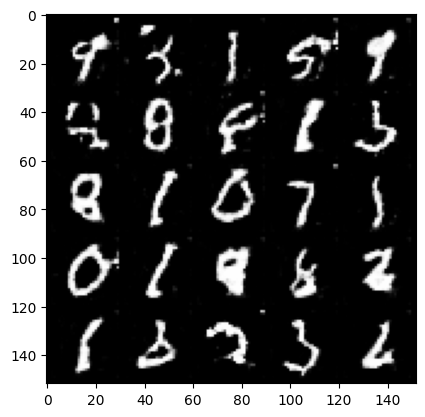

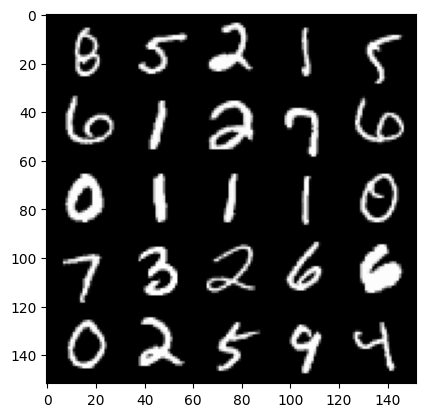

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 0.7031818987131117, discriminator loss: 0.6995310242176059


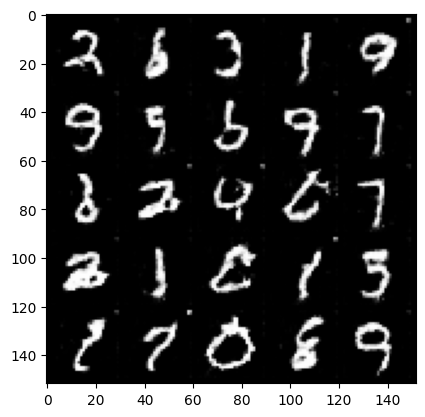

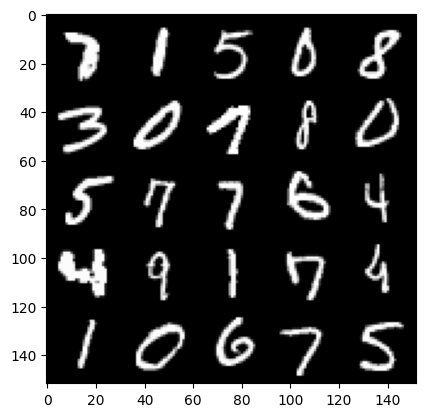

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.7034403523206715, discriminator loss: 0.6994543958902356


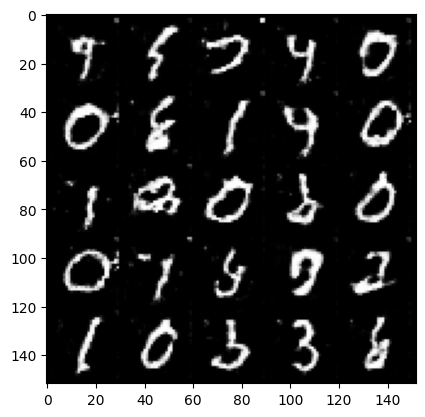

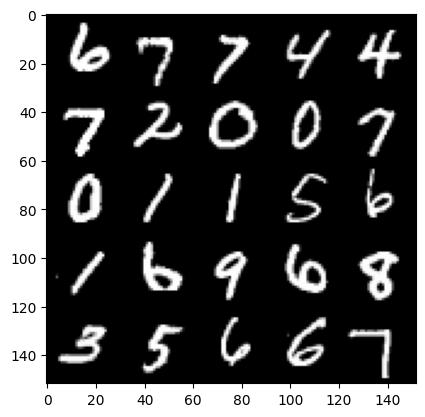

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.7010618735551836, discriminator loss: 0.699126621127128


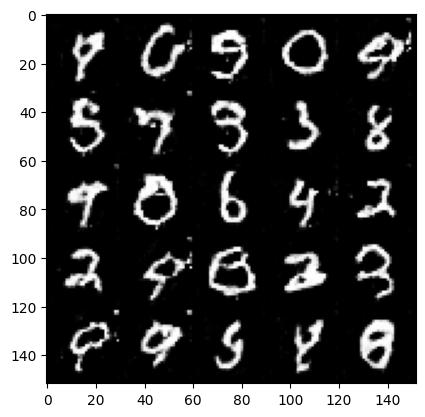

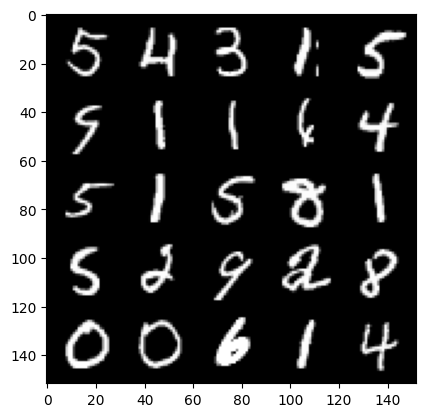

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.7003402469158178, discriminator loss: 0.6986480996608734


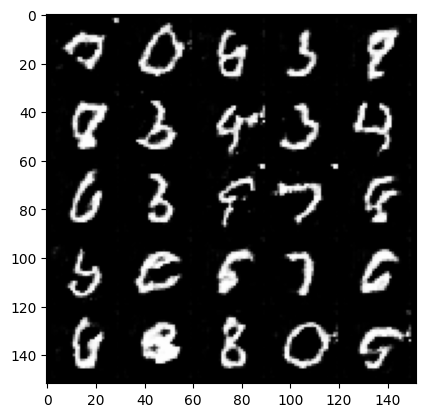

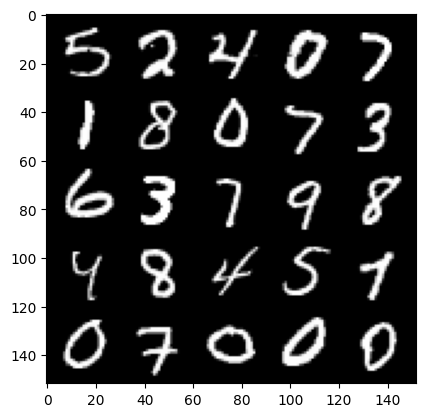

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 0.6996405791044237, discriminator loss: 0.6979590910673138


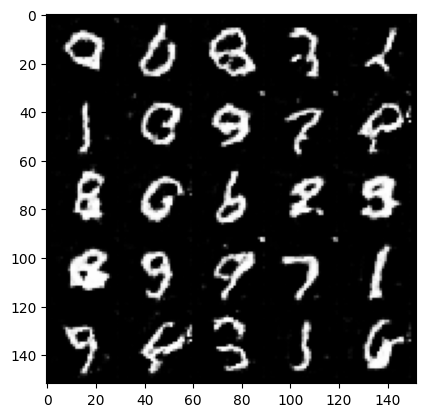

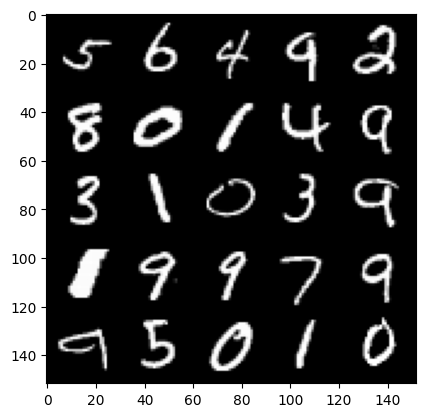

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.6982123476266859, discriminator loss: 0.6982492568492887


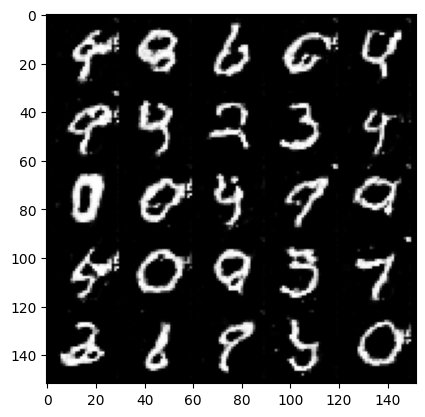

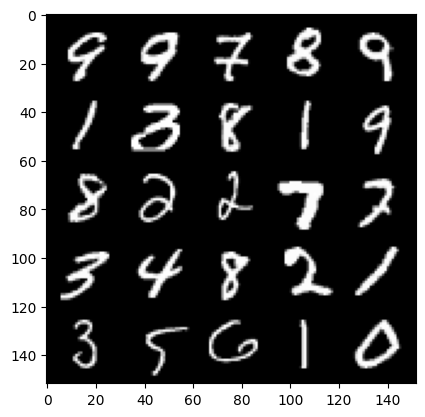

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 0.6991025176048279, discriminator loss: 0.6977119953632361


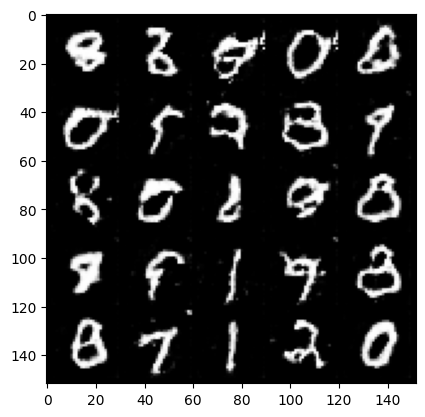

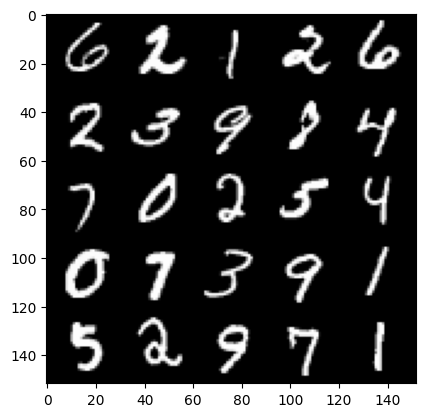

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.698750883817673, discriminator loss: 0.6971155335903164


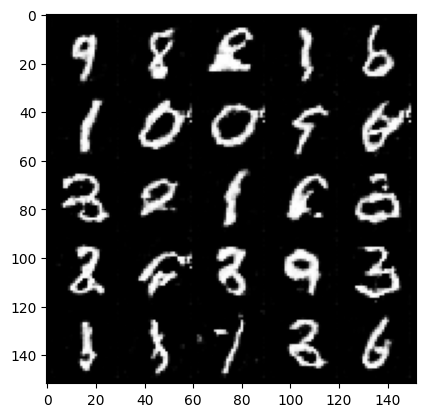

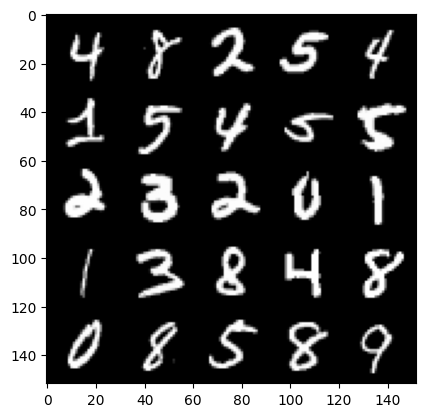

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 0.6967400921583187, discriminator loss: 0.6967571582794192


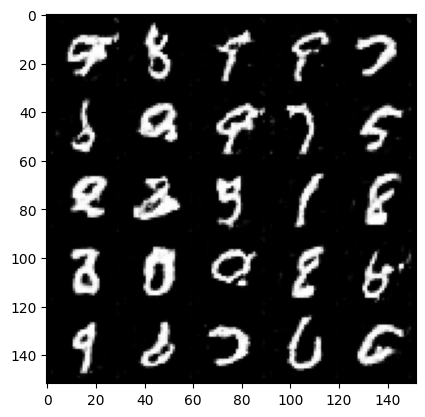

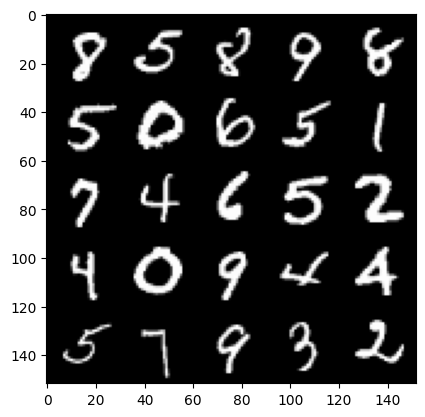

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 0.6978420630693435, discriminator loss: 0.6963192386627203


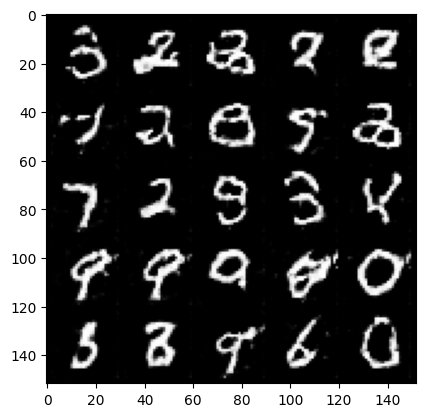

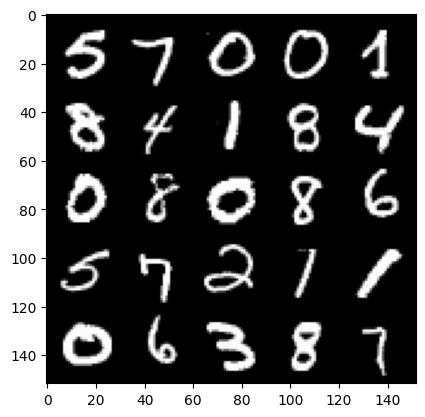

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 0.6979348143339151, discriminator loss: 0.6956448128223418


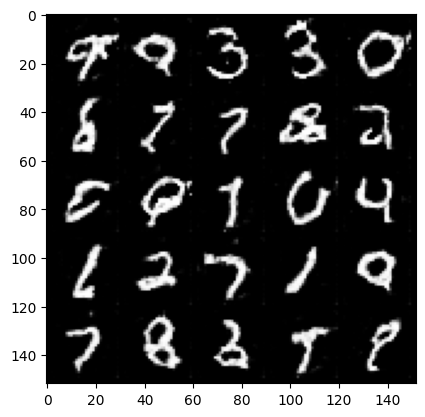

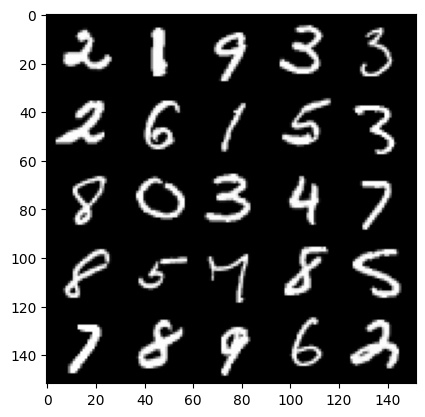

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.6984769754409788, discriminator loss: 0.6953218317031856


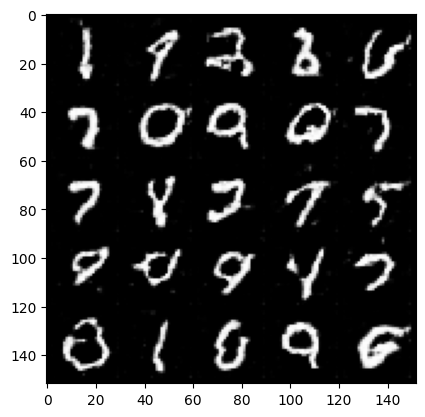

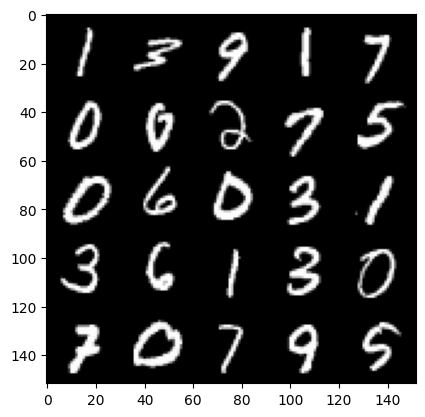

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 0.6974168395996091, discriminator loss: 0.6953874882459641


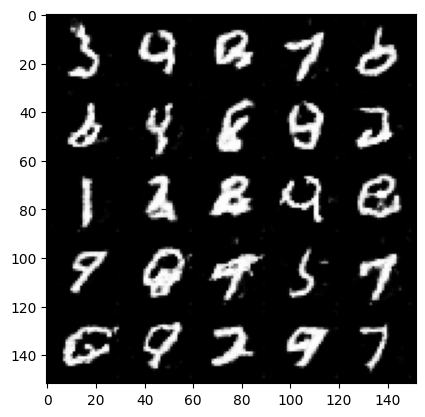

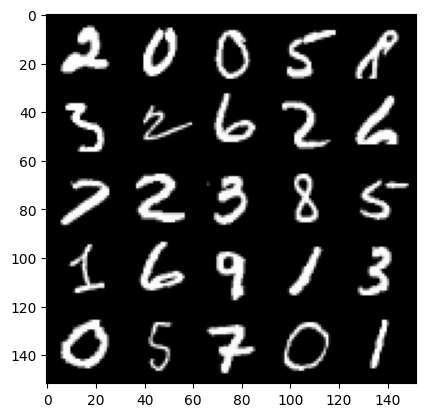

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 0.6978493483066563, discriminator loss: 0.694984550356865


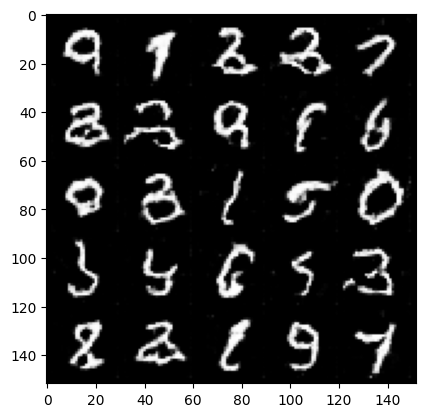

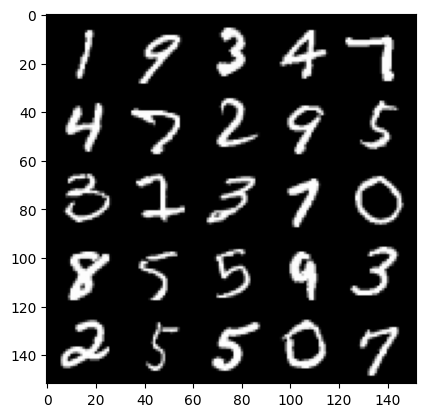

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 0.6990919163227078, discriminator loss: 0.6949478688240063


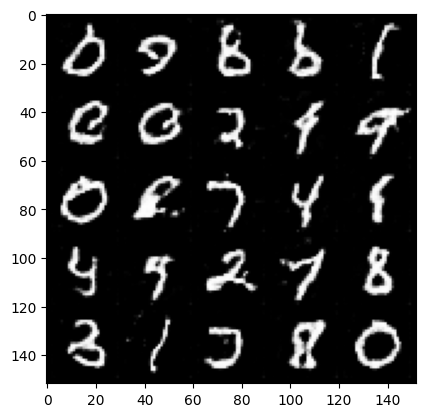

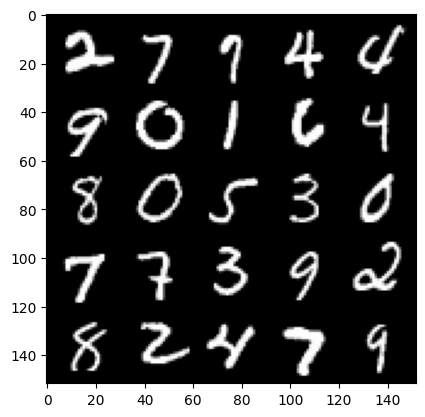

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 0.6977058984041218, discriminator loss: 0.6946682895421985


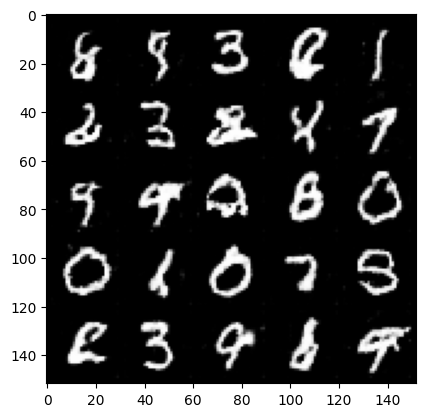

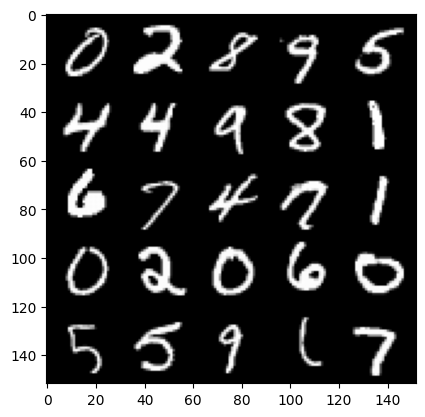

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 0.6962189499139796, discriminator loss: 0.6945014328956599


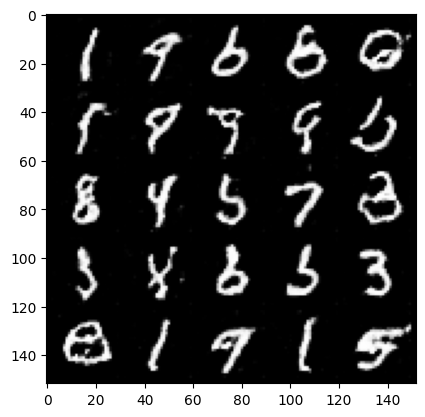

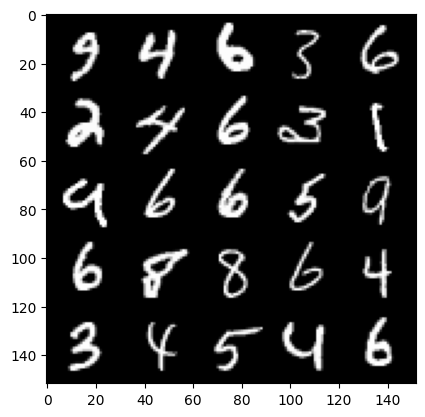

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 0.6970696200132381, discriminator loss: 0.6945477510690689


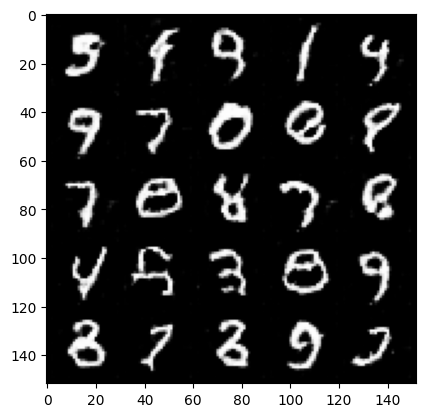

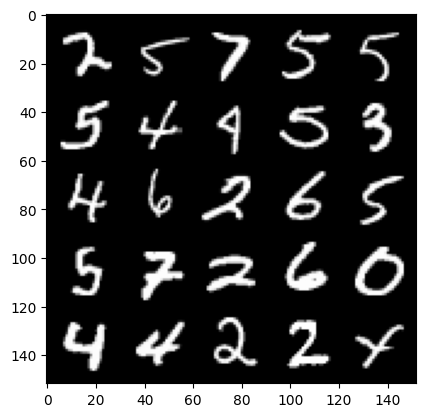

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 0.6978457915782931, discriminator loss: 0.6944733984470374


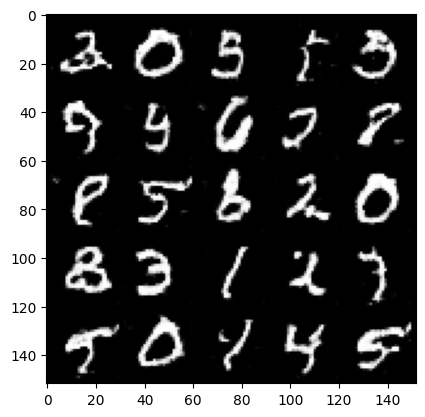

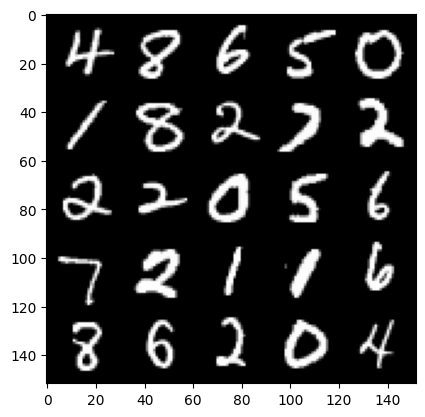

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 0.6963158541917794, discriminator loss: 0.6942945609092708


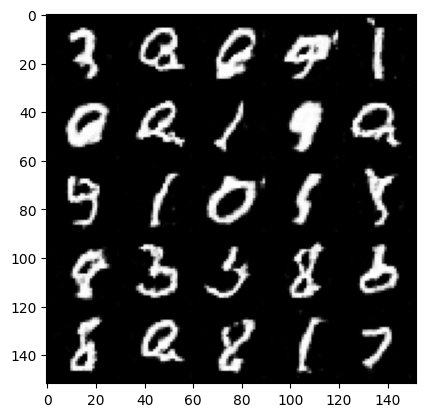

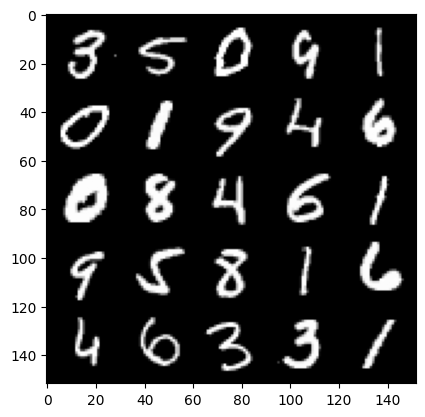

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 0.6965023171901706, discriminator loss: 0.6942408792972562


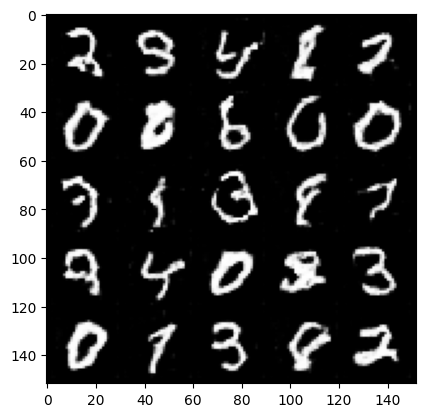

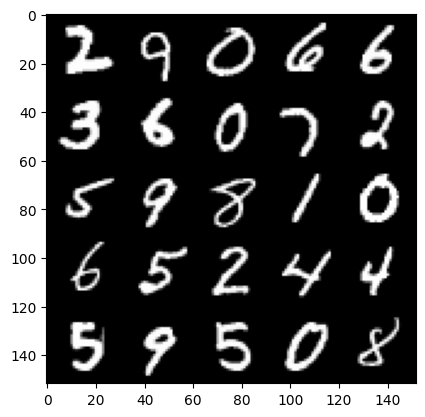

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 0.6981353791952134, discriminator loss: 0.6942893476486215


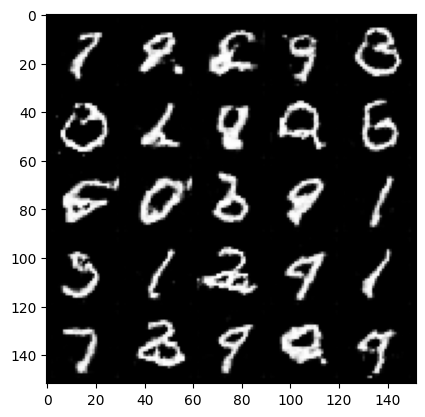

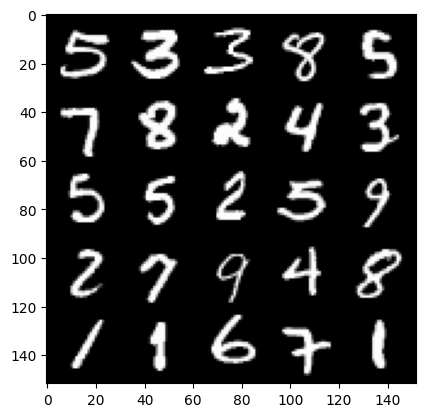

In [ ]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1